# **Project user guide**
### How to use the Markowitz Portfolio Simulator ?

In [42]:
import os
import pickle
import sys
import subprocess
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
import seaborn as sns

## I. Main objectives

The **main objective** of this project is to build a **user-friendly and efficient portfolio optimization tool** based on **Markowitz’s Modern Portfolio Theory**.

💡 **Why this project?**  
This projet acts as a first sight of managing the risk of a portfolio and trying to retrieve the maximum expected return. It then provides :

✅ **An intuitive Streamlit interface** to input investment preferences  
✅ **Automated portfolio optimization** using different strategies  
✅ **Clear visualizations** to help users interpret results  

---
❓ **What is the Markowitz model ?**
The **Markowitz Model** (1952) is a **quantitative framework** that seeks to construct an **optimal portfolio** by maximizing expected return for a given level of risk (variance). The key idea is **diversification**, where combining assets with different return patterns can **reduce overall portfolio risk**.

We are trying to find the best compromise between return and risk :
- The expected return is calculated as a weighted average of the returns on each asset, according to their weight in the portfolio.
- Risk is measured by portfolio volatility, which depends not only on the volatility of individual assets, but also on how they move together (correlations).
- The aim is to maximise return while minimising risk, often by optimising the Sharpe ratio, which compares risk-adjusted return.
- To ensure that the portfolio is realistic, constraints are imposed, such as a total investment of 100% and limits on the allocation of each asset.


🔑 **Key Assumptions of the Markowitz Model**
1️⃣ **Investors are rational and risk-averse**  
   → They prefer **higher returns** for the **same risk** and **lower risk** for the **same return**.  

2️⃣ **Asset returns follow a normal distribution**  
   → Implies that **mean and variance** fully describe the return distribution.  

3️⃣ **No transaction costs or taxes**  
   → Assumes a **frictionless market** where buying and selling are costless.  

4️⃣ **Investors base decisions only on expected return and risk (variance)**  
   → They ignore higher moments like **skewness** and **kurtosis**.  

5️⃣ **Historical data is representative of future returns**  
   → Assumes **past trends persist** into the future.  

---
❌ **Limitations of the Model**
**1. Sensitivity to input parameters**  
   - Small changes in **expected returns or covariances** can lead to very different portfolios.  

**2. Normal distribution assumption**  
   - Financial returns **often exhibit skewness and fat tails**, making variance a **poor risk measure** in extreme market conditions.  

**3. Ignores liquidity and market impact**  
   - The model **does not consider trading costs** or **the ability to execute large trades without impacting prices**.  

**4. Risk is defined only as variance**  
   - Variance includes both **upside and downside risk**, while investors mainly care about **drawdowns**.  

**5. Unrealistic assumptions**  
   - The **no transaction costs** assumption is not applicable to real-world investing.  

---
📌 **Conclusion**  
While the Markowitz Model has limitations, it remains **one of the most fundamental tools** in **portfolio management**. By implementing **realistic constraints, multiple optimization objectives, and a user-friendly interface**, this project makes **quantitative portfolio construction** accessible to all investors.


## II. Explanation of the different parts

The project is structured in several parts:

The `data/` folder contains everything to do with retrieving tickers and interacting with the user via the Streamlit interface. This is where the responses are recorded before being used for optimisation.

The main processes are stored in the `main/` folder: `statistics.py` calculates asset returns, volatilities and correlations, while `portfolio_optimizer.py` uses this data to optimise the portfolio allocation according to the constraints defined. The results are then stored in `optimized_portfolio.pkl`.

The `tests` folder is used to validate the correct operation of the project using several test scenarios (5, 10 and 20 assets). `run_tests`.py automates the execution of these tests to ensure that the optimisation works correctly.

Finally, the `portfolio_optimizer_tutorial.ipynb` file serves as an interactive step-by-step guide to using the project. The **README.md** describes the entire project, while `requirements.txt` lists the dependencies required to run it.

## III. Question Interface

![Description de l'image](appendices/Question.py.jpg)

Let's decompose the question pannel in 2 parts :
On the left side, we can play on different cursors. For an easy analyse, we will not touch the default settings, which means that we keep :
- Risk level : Low
- Total amount to invest : 10000
- Minimum allowance : 5%
- Maximum allowance : 50%
- Rebalancing frequency (not really needed in this project but useful for others projects i am working on) : Daily
- Include dividend payments : No
- Risk free rate : 1.5%

On the right side, we have to choose the tickers/assets and the optimisation method :
- Optimisation method : Maximising the sharpe ratio
For the example, we will use the following tickers:
- "AAPL": Apple (Tech giant, leader in smartphones and digital services.)
- "MSFT": Microsoft (Leader in software, cloud computing and artificial intelligence.)
- "TSLA": Tesla (Manufacturer of electric cars and a key player in renewable energy.)
- "AMZN": Amazon (Online retail giant, Amazon is also a leader in cloud computing with AWS, logistics, streaming and artificial intelligence).
- "GOOGL": Alphabet (parent company of Google, leader in search engines and digital advertising.)
- "ASML": ASML Holding (Leading Dutch manufacturer of semiconductor machinery.)
- "VRTX": Vertex Pharmaceuticals (biotech company specialising in genetic treatments).
- "CDNS": Cadence Design Systems (Specialist in electronic design software.)
- "WST": West Pharmaceutical Services (Manufacturer of solutions for the pharmaceutical industry.)
- "FTNT": Fortinet (Company specialising in cybersecurity and network protection).


Then we send the information via the "Valider et Lancer l'optimisation" bouton !

## IV. Statistics code

`statistics.py` calculates key financial metrics for the selected assets. It retrieves historical price data, computes average returns, volatility, and the covariance matrix. These statistics serve as the foundation for portfolio optimization by estimating risk and expected returns.

In [27]:
# 📌 Définition des chemins de fichiers
ANSWERS_FILE = "/home/onyxia/work/Markowitz_Portfolio_Sim/data/answers.pkl"
if not os.path.exists(ANSWERS_FILE):
    print(f"❌ Fichier introuvable : '{ANSWERS_FILE}'\nAssurez-vous que les réponses ont bien été enregistrées depuis `interface.py`.")
with open(ANSWERS_FILE, "rb") as f:
    user_answers = pickle.load(f)
print(user_answers)

# 📌 Extraction des tickers validés
tickers_selected = user_answers.get("tickers", [])

print("\n✅ Tickers validés par l'utilisateur :")
print(tickers_selected)

data = yf.download(tickers_selected, period="5y", interval="1d", group_by="ticker")
if isinstance(data.columns, pd.MultiIndex):
    adj_close = data.xs("Close", level=1, axis=1)
else :
    adj_close = data["Close"]
adj_close.dropna()
data = data.pct_change().dropna()

[                       0%                       ]

{'tickers': ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOGL', 'ASML', 'VRTX', 'CDNS', 'WST', 'FTNT'], 'risk_level': 'Faible', 'budget': 10000, 'min_allocation': 5, 'max_allocation': 50, 'rebalance_frequency': 'Journalier', 'include_dividends': False, 'risk_free_rate': 1.5, 'optimization_method': 'Maximisation du ratio de Sharpe', 'target_return': None}

✅ Tickers validés par l'utilisateur :
['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOGL', 'ASML', 'VRTX', 'CDNS', 'WST', 'FTNT']


[*********************100%***********************]  10 of 10 completed


**The Expected Return**

In [36]:
mean_returns = returns.mean()  # 📌 Rendement moyen journalier
annualized_returns = mean_returns * 252 * 100  # 📌 Conversion en rendement annuel

annualized_returns_close = annualized_returns.xs("Close", level=1)  
formatted_returns = annualized_returns_close.map(lambda x: f"{x:.2f}%")  

print("📈 Rendements annuels des actifs sélectionnés (Close) :")
print(formatted_returns)

📈 Rendements annuels des actifs sélectionnés (Close) :
Ticker
FTNT     40.79%
GOOGL    23.48%
ASML     27.62%
TSLA     60.75%
CDNS     34.88%
VRTX     18.19%
AMZN     21.79%
WST      20.59%
MSFT     21.14%
AAPL     26.50%
dtype: object


**The Volatility**

In [37]:
volatility = data.std()
annualized_volatility = volatility * (252 ** 0.5)

annualized_volatility_close = annualized_volatility.xs("Close", level=1)

print("📊 Volatilité annuelle des actifs sélectionnés (Close) :")
print(annualized_volatility_close)

📊 Volatilité annuelle des actifs sélectionnés (Close) :
Ticker
FTNT     0.455579
TSLA     0.658255
ASML     0.436364
AAPL     0.317618
AMZN     0.359279
GOOGL    0.327584
WST      0.356112
VRTX     0.318102
MSFT     0.306078
CDNS     0.374058
dtype: float64


**The Covariance Matrix**

In [38]:
cov_matrix = data.cov()
cov_matrix_annualized = cov_matrix.xs("Close", level=1, axis=0).xs("Close", level=1, axis=1) * 252

print("🔄 Matrice de Covariance Annuelle des Rendements (Close) :")
print(cov_matrix_annualized)

🔄 Matrice de Covariance Annuelle des Rendements (Close) :
Ticker      FTNT      TSLA      ASML      AAPL      AMZN     GOOGL       WST  \
Ticker                                                                         
FTNT    0.207552  0.110804  0.095885  0.071037  0.072517  0.067697  0.061417   
TSLA    0.110804  0.433299  0.126189  0.103504  0.104754  0.088626  0.063036   
ASML    0.095885  0.126189  0.190413  0.078060  0.084456  0.079072  0.059473   
AAPL    0.071037  0.103504  0.078060  0.100881  0.068453  0.066910  0.046193   
AMZN    0.072517  0.104754  0.084456  0.068453  0.129081  0.076963  0.050797   
GOOGL   0.067697  0.088626  0.079072  0.066910  0.076963  0.107311  0.047714   
WST     0.061417  0.063036  0.059473  0.046193  0.050797  0.047714  0.126816   
VRTX    0.041693  0.046342  0.042899  0.040366  0.032672  0.037890  0.035707   
MSFT    0.075467  0.089599  0.083001  0.072154  0.075040  0.073895  0.052867   
CDNS    0.088966  0.111285  0.114504  0.072160  0.078696  0.07

We get :
- Annual expected return
- Annual volatility
- Annuel covariance matrix

## V. Portfolio_Optimizer code

Now we are going to use this data to find the perfect balance of assets. The `portfolio_optimizer.py` script takes asset return statistics (expected returns, volatility, and covariance matrix) and optimizes portfolio allocation based on user-defined constraints.

In [52]:
with open("data/answers.pkl", "rb") as f:
    user_preferences = pickle.load(f)

budget = user_preferences["budget"]
min_allocation = user_preferences["min_allocation"] / 100
max_allocation = user_preferences["max_allocation"] / 100
risk_free_rate = user_preferences["risk_free_rate"] / 100
optimization_method = user_preferences["optimization_method"]

num_assets = len(annualized_returns_close)

bounds = [(min_allocation, max_allocation) for _ in range(num_assets)]
constraints = {"type": "eq", "fun": lambda weights: np.sum(weights) - 1}

if optimization_method == "Maximisation du ratio de Sharpe":
    def neg_sharpe_ratio(weights):
        port_return = np.dot(weights, annualized_returns_close)
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annualized, weights)))
        return - (port_return - risk_free_rate) / port_volatility  # Maximisation du Sharpe

    result = sco.minimize(neg_sharpe_ratio, np.ones(num_assets) / num_assets,
                          method="SLSQP", bounds=bounds, constraints=constraints)

elif optimization_method == "Minimisation de la volatilité":
    def min_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annualized, weights)))

    result = sco.minimize(min_volatility, np.ones(num_assets) / num_assets,
                          method="SLSQP", bounds=bounds, constraints=constraints)

if result.success:
    optimal_weights = result.x
    expected_return = np.dot(optimal_weights, annualized_returns_close)  # Rendement attendu
    expected_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix_annualized, optimal_weights)))  # Volatilité attendue
    investment_amounts = optimal_weights * budget  # Montant investi par actif

    print("\n✅ Optimisation réussie !")
    print(f"📈 Rendement attendu : {expected_return:.2f}%")
    print(f"📊 Volatilité attendue : {expected_volatility:.2f}%\n")

    print("🛠 Répartition optimale du portefeuille :")
    for asset, weight in zip(annualized_returns_close.index, optimal_weights):
        print(f"{asset}: {weight * 100:.2f}%")

    print("\n💰 Montants investis :")
    for asset, amount in zip(annualized_returns_close.index, investment_amounts):
        print(f"{asset}: {amount:.2f}€")

else:
    print(f"❌ Échec de l'optimisation : {result.message}")


✅ Optimisation réussie !
📈 Rendement attendu : 43.54%
📊 Volatilité attendue : 0.28%

🛠 Répartition optimale du portefeuille :
FTNT: 6.92%
GOOGL: 5.00%
ASML: 5.00%
TSLA: 50.00%
CDNS: 5.00%
VRTX: 5.00%
AMZN: 5.00%
WST: 8.08%
MSFT: 5.00%
AAPL: 5.00%

💰 Montants investis :
FTNT: 692.39€
GOOGL: 500.00€
ASML: 500.00€
TSLA: 5000.00€
CDNS: 500.00€
VRTX: 500.00€
AMZN: 500.00€
WST: 807.61€
MSFT: 500.00€
AAPL: 500.00€


We can see the breakdown and the different amounts invested.

## VI. Answer interface

On the Answer interface (still the same as the question), the answers are described and 3 graphs are displayed. You can see them below

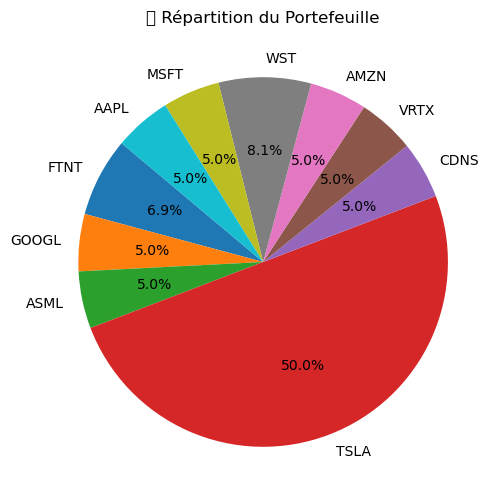

In [53]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(optimal_weights * 100, labels=annualized_returns_close.index, autopct='%1.1f%%', startangle=140)
ax.set_title("📊 Répartition du Portefeuille")
plt.show()

[*********************100%***********************]  11 of 11 completed
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


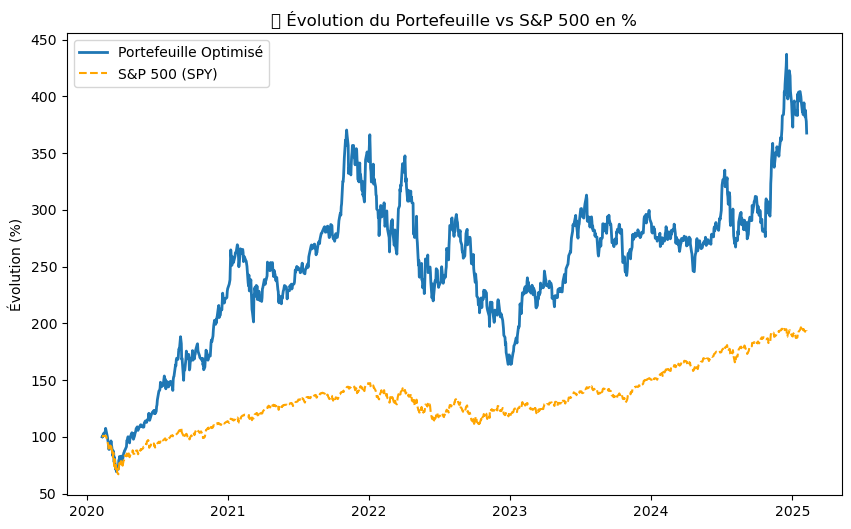

In [54]:
tickers = list(annualized_returns_close.index) + ["SPY"]
stock_data = yf.download(tickers, period="5y")["Close"]

if stock_data.isnull().values.any():
    print("⚠️ Des valeurs manquantes ont été détectées. Elles seront supprimées.")
    stock_data = stock_data.dropna()

weighted_prices = stock_data[annualized_returns_close.index].mul(optimal_weights, axis=1)
portfolio_value = weighted_prices.sum(axis=1)

portfolio_returns = (portfolio_value / portfolio_value.iloc[0]) * 100
spy_returns = (stock_data["SPY"] / stock_data["SPY"].iloc[0]) * 100

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(portfolio_returns, label="Portefeuille Optimisé", linewidth=2)
ax.plot(spy_returns, label="S&P 500 (SPY)", linestyle="dashed", color="orange")

ax.set_title("📈 Évolution du Portefeuille vs S&P 500 en %")
ax.set_ylabel("Évolution (%)")
ax.legend()
plt.show()

/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


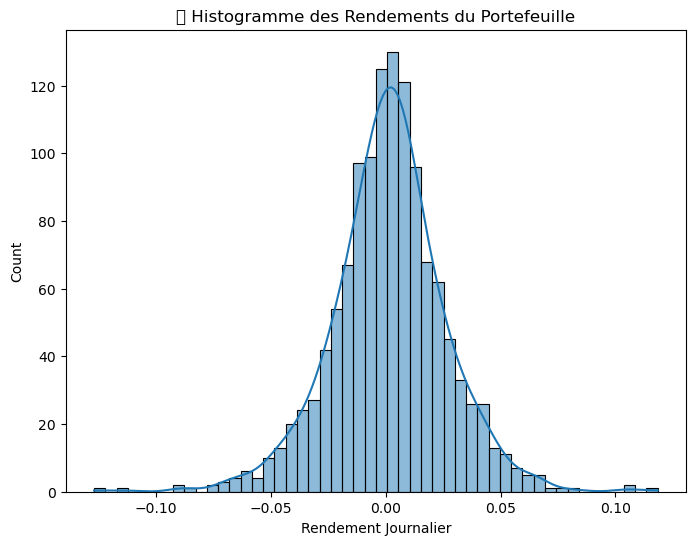

In [51]:
daily_returns = portfolio_value.pct_change().dropna()

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(daily_returns, bins=50, kde=True, ax=ax)
ax.set_title("📊 Histogramme des Rendements du Portefeuille")
ax.set_xlabel("Rendement Journalier")
plt.show()

## VII. Analyse of the 3 strategies

- Sharpe Ratio Maximization balances risk and return, making it ideal for steady long-term growth. It performs well in bull markets but can be volatile in downturns.
- Volatility Minimization prioritizes stability, reducing risk but often leading to lower returns. It excels in bear markets but underperforms in rallies.
- Target Return Optimization ensures a specific return but may take excessive risks if the target is too high. It requires regular adjustments based on market conditions.

🔎 Key Takeaways:
- **For balanced growth** : Sharpe Ratio is the best choice.
- **For low-risk investing** : Volatility Minimization is preferable.
- **For fixed goals** : Target Return works, but only if realistic.

## VIII. The limits

- **Markowitz Assumptions** : It relies on historical data, assuming past trends predict the future, which ignores market shocks.
- **Risk Estimation** : Volatility does not capture tail risks, making it less effective during crises.
- **Optimization Constraints** : The model may fail if constraints are too strict, leading to infeasible solutions.
- **Data Dependence** : Performance relies on accurate data; errors in price feeds can distort results.
- **Execution Limitations** : The code does not account for liquidity or transaction costs, affecting real-world applicability.

## IX. Next steps ?

- **Automated Asset Selection** : Implement a system to suggest optimal tickers based on market data, user risk profile, and past performance.
- **Custom Data Import** : Allow users to upload their own price data for more flexibility (e.g., private assets, alternative data).
- **More Robust Constraints Handling** : Improve optimization to relax constraints dynamically if the problem is infeasible.
- **Integration of Transaction Costs & Liquidity** : Incorporate trading fees and liquidity constraints to make results more realistic.
- **Dynamic Rebalancing Feature** : Add rebalancing strategies to adjust allocations over time based on market conditions.
- **Additional Performance Metrics** : Expand analysis with drawdown, Sharpe ratio evolution, and stress testing.
- **User-Friendly Interface Enhancements** : Improve Streamlit UI, with more visualization options and interactive explanations.
- **Fixed Income & Alternative Assets** : Add bonds, commodities, and ETFs to improve portfolio diversification.
- **Live Market Data Integration** : Implement real-time price updates for continuous portfolio monitoring.